# 🔬 Embryo Viability Classifier - F15 Focal Plane

## Member 1 Training Notebook

**Dataset:** Human embryo time-lapse videos (F15 focal plane - 8.9 GB)  
**Features:** 20 features (16 morphological + 4 temporal)  
**Expected Accuracy:** 85-90%

---

## 📦 Outputs Generated:
1. `embryo_model_F15.pkl` - Trained Random Forest model
2. `scaler_F15.pkl` - Feature scaler (StandardScaler)
3. `results_F15.json` - Evaluation metrics
4. `feature_names_F15.json` - Feature column names
5. `confusion_matrix_F15.png` - Visualization

**⚠️ IMPORTANT:** All members must generate the same 5 files with their focal plane suffix (F15/F30/F45)

---
## 1️⃣ Setup Environment

In [ ]:
# Force clean reinstall to fix broken sklearn
!pip uninstall -y numpy scikit-learn scipy imbalanced-learn -q
!pip install --no-cache-dir -q "numpy>=2.0,<2.1" "scikit-learn>=1.6.0" "scipy>=1.13.0"
!pip install --no-cache-dir -q imbalanced-learn opencv-python matplotlib seaborn pandas tqdm joblib

print("\n" + "="*60)
print("✅ CLEAN INSTALLATION COMPLETE!")
print("="*60)
print("📦 All packages reinstalled without cache")
print("\n🔄 MANDATORY: RESTART RUNTIME NOW!")
print("   1. Runtime > Restart runtime")
print("   2. After restart, SKIP this cell")
print("   3. Run Cell 3 (imports)")
print("\n💡 The restart is REQUIRED to load fresh packages")
print("="*60)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 225.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 290.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 251.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 172.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 50.6 MB/s eta 0:00:00

✅ CLEAN INSTALLATION COMPLETE!
📦 All packages reinstalled without cache

🔄 MANDATORY: RESTART RUNTIME NOW!
   1. Runtime > Restart runtime
   2. After restart, SKIP this cell
   3. Run Cell 3 (imports)

💡 The restart is REQUIRED to load fresh packages


In [ ]:
# Now that numpy and scikit-learn are pinned in the initial installation cell (c2f94216),
# and runtime restart is expected, this re-installation is no longer needed here.
# If you run into issues, consider restarting the runtime and re-running all cells.

# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE

print("✅ All imports successful!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All imports successful!
OpenCV version: 4.12.0
NumPy version: 2.0.2
Pandas version: 2.2.2


In [ ]:
# Mount Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

print("✅ Google Drive mounted!")

Mounted at /content/drive
✅ Google Drive mounted!


In [ ]:
# Configuration
FOCAL_PLANE = "F45"
DATASET_FILE = "embryo_dataset_F45.tar.gz"
ANNOTATIONS_FILE = "embryo_dataset_annotations.tar.gz"

print(f"""\n{'='*60}
⚙️ CONFIGURATION
{'='*60}
Focal Plane: {FOCAL_PLANE}
Dataset: {DATASET_FILE}
Expected Size: 8.9 GB
{'='*60}\n""")


⚙️ CONFIGURATION
Focal Plane: F45
Dataset: embryo_dataset_F45.tar.gz
Expected Size: 8.9 GB



---
## 2️⃣ Download & Extract Dataset

### Option A: Upload from your computer
### Option B: Download from Zenodo
### Option C: Copy from Google Drive (if already uploaded)

In [ ]:
# Extract dataset from Google Drive (already downloaded)
import os
import tarfile
from pathlib import Path

print("📦 EXTRACTING DATASET FROM GOOGLE DRIVE")
print("="*60)

# Location where you downloaded the dataset
source_dir = "/content/drive/MyDrive/gfgIVF"
extract_to = "/content/drive/MyDrive/gfgIVF/embryo_data"  # Extract to Colab local storage for faster access

print(f"📁 Source: {source_dir}")
print(f"📁 Extract to: {extract_to}")

# Create extraction directory
os.makedirs(extract_to, exist_ok=True)

# Check what files are in Google Drive
print(f"\n🔍 Checking files in {source_dir}...")
if os.path.exists(source_dir):
    files_in_drive = os.listdir(source_dir)
    print(f"✅ Found {len(files_in_drive)} items")

    # Show all items
    print("\n📂 Items in Drive:")
    for item in files_in_drive:
        item_path = os.path.join(source_dir, item)
        if os.path.isfile(item_path):
            size_mb = os.path.getsize(item_path) / (1024*1024)
            print(f"   📄 {item} ({size_mb:.1f} MB)")
        else:
            print(f"   📁 {item}/")

    # Find tar.gz files
    tar_files = [f for f in files_in_drive if f.endswith('.tar.gz') or f.endswith('.tgz')]

    if tar_files:
        print(f"\n📦 Found {len(tar_files)} TAR.GZ file(s)")

        # Ask which file to extract (or extract F30 by default)
        print("\n💡 Extracting embryo_dataset_F45.tar.gz...")
        target_file = "embryo_dataset_F45.tar.gz"

        if target_file in tar_files:
            tar_path = os.path.join(source_dir, target_file)
            print(f"\n📥 Extracting: {target_file}")
            print(f"   Size: {os.path.getsize(tar_path) / (1024*1024*1024):.1f} GB")
            print("   ⏳ This will take 5-15 minutes...")

            try:
                with tarfile.open(tar_path, 'r:gz') as tar_ref:
                    # Extract all files
                    tar_ref.extractall(extract_to)
                    print(f"   ✅ Extracted successfully!")
            except Exception as e:
                print(f"   ❌ Error: {str(e)}")
        else:
            print(f"   ⚠️ {target_file} not found in Drive!")

        print("\n" + "="*60)
        print("✅ EXTRACTION COMPLETE!")
        print("="*60)

        # Show extracted structure
        print("\n📂 Extracted structure:")
        !ls -lh {extract_to}

        # Count images
        print("\n🔍 Counting images...")
        image_count = 0
        for root, dirs, files in os.walk(extract_to):
            image_count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
        print(f"✅ Found {image_count} images!")

    else:
        print("\n⚠️ No TAR.GZ files found!")
        print("💡 Looking for images directly in Drive...")

        # Check if images exist directly in Drive
        image_files = [f for f in files_in_drive if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if image_files:
            print(f"✅ Found {len(image_files)} images directly in Drive")
            print("💡 Using images from Google Drive directly (no extraction needed)")
        else:
            print("❌ No images or TAR.GZ files found!")
            print("📋 Available files:")
            for f in files_in_drive:
                print(f"   - {f}")
else:
    print(f"❌ Directory not found: {source_dir}")
    print("\n💡 Update the 'source_dir' path to match your Google Drive location")
    print("   Common locations:")
    print("   - /content/drive/MyDrive/gfgIVF")
    print("   - /content/drive/MyDrive/EmbryoProject")
    print("   - /content/drive/MyDrive/[your-folder-name]")

📦 EXTRACTING DATASET FROM GOOGLE DRIVE
📁 Source: /content/drive/MyDrive/gfgIVF
📁 Extract to: /content/drive/MyDrive/gfgIVF/embryo_data

🔍 Checking files in /content/drive/MyDrive/gfgIVF...
✅ Found 7 items

📂 Items in Drive:
   📁 embryo_data/
   📄 embryo_dataset_F30.tar.gz (7779.4 MB)
   📄 embryo_dataset_F-45.tar.gz (7696.8 MB)
   📄 embryo_dataset_F45.tar.gz (6976.2 MB)
   📄 embryo_dataset.tar.gz (11584.7 MB)
   📄 embryo_dataset_annotations.tar.gz (0.1 MB)
   📄 embryo_dataset_F-15.tar.gz (16.0 MB)

📦 Found 6 TAR.GZ file(s)

💡 Extracting embryo_dataset_F45.tar.gz...

📥 Extracting: embryo_dataset_F45.tar.gz
   Size: 6.8 GB
   ⏳ This will take 5-15 minutes...


/tmp/ipython-input-2940161663.py:54: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(extract_to)


   ✅ Extracted successfully!

✅ EXTRACTION COMPLETE!

📂 Extracted structure:
total 8.0K
drwx------   2 root root 4.0K Jan 24 12:05 embryo_dataset_F30
drwx------ 706 root root 4.0K Mar 22  2022 embryo_dataset_F45

🔍 Counting images...
✅ Found 422894 images!


In [ ]:
# ============================================================
# 3️⃣ FIND ALL IMAGES
# ============================================================
# Find all image files
import glob

print("🔍 Searching for image files...")

# Search for image formats in multiple locations
image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']
image_files = []

# Try multiple locations (prioritize local, fallback to Drive)
search_paths = [
    # '/content/embryo_data',                                           # Local Colab storage (fastest)
    '/content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45',  # F45 dataset in Drive
    # '/content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F30',  # F30 dataset in Drive
    # '/content/drive/MyDrive/gfgIVF/embryo_data',                     # All datasets in Drive
]

found_location = None
for search_path in search_paths:
    if os.path.exists(search_path):
        found_location = search_path
        storage_type = "local Colab storage" if "drive" not in search_path else "Google Drive"
        print(f"\n📂 Searching in: {search_path}")
        print(f"   Storage: {storage_type}")
        print(f"   ⏳ Please wait... (Google Drive searches can take 5-10 minutes)")

        for ext in image_extensions:
            print(f"\n   Searching for {ext} files...")
            found = glob.glob(f'{search_path}/**/{ext}', recursive=True)
            if found:
                image_files.extend(found)
                print(f"   ✅ Found {len(found)} {ext} files")

        if len(image_files) > 0:
            print(f"\n   🎉 Successfully found images in {storage_type}!")
            break  # Stop searching once we find images
        else:
            print(f"   ⚠️ No images found in this location, checking next...")

if found_location is None:
    print("\n❌ Dataset not found in any location!")
    print("\n💡 Please check:")
    print("   1. Mount Google Drive (Cell 4)")
    print("   2. Verify data location in your Drive")
    print("   3. Update search_paths in this cell if needed")

# Remove duplicates
image_files = list(set(image_files))

print(f"\n{'='*60}")
print(f"✅ FOUND {len(image_files)} TOTAL IMAGE FILES")
print(f"{'='*60}")

if len(image_files) > 0:
    print(f"\n📸 Sample images (first 10):")
    for img in image_files[:10]:
        print(f"   {img}")

    if len(image_files) > 10:
        print(f"   ... and {len(image_files) - 10} more images")

    # Check directory structure to understand labeling
    print(f"\n📊 Analyzing directory structure for labels...")
    dirs_with_images = set()
    for img_path in image_files[:100]:  # Sample first 100
        parent_dir = os.path.basename(os.path.dirname(img_path))
        dirs_with_images.add(parent_dir)

    print(f"   Images found in these folders: {sorted(dirs_with_images)}")

else:
    print("\n⚠️ No image files found!")
    print("\n💡 Checking directory contents...")
    for path in search_paths:
        if os.path.exists(path):
            print(f"\n📂 Contents of {path}:")
            !ls -lh {path} | head -20

🔍 Searching for image files...

📂 Searching in: /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45
   Storage: Google Drive
   ⏳ Please wait... (Google Drive searches can take 5-10 minutes)

   Searching for *.png files...

   Searching for *.jpg files...

   Searching for *.jpeg files...
   ✅ Found 163644 *.jpeg files

   Searching for *.bmp files...

   🎉 Successfully found images in Google Drive!

✅ FOUND 163644 TOTAL IMAGE FILES

📸 Sample images (first 10):
   /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/PA1217-8/D2013.12.14_S0981_I132_WELL8_RUN349.jpeg
   /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/RV454-6/D2014.05.22_S1107_I132_WELL6_RUN450.jpeg
   /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/RC545-2-5/D2016.06.13_S1675_I132_WELL5_RUN177.jpeg
   /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/BM209-8/D2014.03.05_S1037_I132_WELL8_RUN235.jpeg
   /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/LS058

In [ ]:
# Load annotations (embryo labels)
print("📋 Loading embryo annotations...")

# Check what's in the annotations directory
annotations_dir = "/content/drive/MyDrive/gfgIVF/embryo_dataset_annotations/embryo_dataset_annotations"

if os.path.exists(annotations_dir):
    print(f"✅ Found annotations directory: {annotations_dir}")

    # List files in annotations directory
    print("\n📂 Files in annotations directory:")
    !ls -lh {annotations_dir}

    # Try to find CSV or text files
    import glob
    csv_files = glob.glob(f'{annotations_dir}/*.csv')
    txt_files = glob.glob(f'{annotations_dir}/*.txt')
    json_files = glob.glob(f'{annotations_dir}/*.json')

    print(f"\n🔍 Found:")
    print(f"   CSV files: {len(csv_files)}")
    print(f"   TXT files: {len(txt_files)}")
    print(f"   JSON files: {len(json_files)}")

    # Try to load the first available file
    if csv_files:
        annotations_file = csv_files[0]
        print(f"\n📄 Loading: {os.path.basename(annotations_file)}")

        # Try different separators
        try:
            df_labels = pd.read_csv(annotations_file)
        except:
            try:
                df_labels = pd.read_csv(annotations_file, sep='\t')
            except:
                df_labels = pd.read_csv(annotations_file, sep=';')

        print(f"✅ Loaded {len(df_labels)} annotations")
        print(f"\n📊 Columns: {list(df_labels.columns)}")
        print(f"\n👀 First 10 rows:")
        print(df_labels.head(10))

        # Show unique labels
        print(f"\n🏷️ Checking for label columns...")
        for col in df_labels.columns:
            if 'label' in col.lower() or 'class' in col.lower() or 'outcome' in col.lower() or 'quality' in col.lower():
                print(f"   Found: '{col}' - Unique values: {df_labels[col].unique()}")

    elif txt_files:
        print(f"\n📄 Found TXT file: {txt_files[0]}")
        print("\n👀 First 20 lines:")
        !head -20 {txt_files[0]}

    else:
        print("\n⚠️ No CSV, TXT, or JSON files found in annotations directory")
        print("Showing all files:")
        !ls -la {annotations_dir}

else:
    print(f"❌ Annotations directory not found: {annotations_dir}")
    print("\n💡 Looking for annotations tar.gz file to extract...")

    tar_file = "/content/drive/MyDrive/gfgIVF/embryo_dataset_annotations.tar.gz"
    if os.path.exists(tar_file):
        print(f"✅ Found: {tar_file}")
        print("Extracting...")

        import tarfile
        extract_to = "/content/drive/MyDrive/gfgIVF"

        with tarfile.open(tar_file, 'r:gz') as tar_ref:
            tar_ref.extractall(extract_to)

        print("✅ Extracted! Re-run this cell to load annotations.")
    else:
        print("❌ Annotations file not found!")

📋 Loading embryo annotations...
✅ Found annotations directory: /content/drive/MyDrive/gfgIVF/embryo_dataset_annotations/embryo_dataset_annotations

📂 Files in annotations directory:
total 352K
-rw------- 1 root root 108 Dec  9  2021 AA83-7_phases.csv
-rw------- 1 root root 137 Dec  9  2021 AAL839-6_phases.csv
-rw------- 1 root root  80 Dec  9  2021 AB028-6_phases.csv
-rw------- 1 root root 146 Dec  9  2021 AB91-1_phases.csv
-rw------- 1 root root  98 Dec  9  2021 AC264-1_phases.csv
-rw------- 1 root root 148 Dec  9  2021 ADM715-1-2_phases.csv
-rw------- 1 root root 169 Dec  9  2021 AG274-2_phases.csv
-rw------- 1 root root 127 Dec  9  2021 AG782-6_phases.csv
-rw------- 1 root root  90 Dec  9  2021 AG782-8_phases.csv
-rw------- 1 root root 160 Dec  9  2021 AH988-4_phases.csv
-rw------- 1 root root 113 Dec  9  2021 AHS115-5_phases.csv
-rw------- 1 root root 144 Dec  9  2021 AHS599-4_phases.csv
-rw------- 1 root root 135 Dec  9  2021 AK383-1_phases.csv
-rw------- 1 root root 155 Dec  9  2

In [ ]:
from tqdm import tqdm
import os

In [ ]:
# ============================================================
# LOAD DEVELOPMENTAL ANNOTATIONS & CREATE QUALITY LABELS
# ============================================================
print("📋 Loading developmental annotations and creating quality labels...")
print("="*60)

annotations_dir = "/content/drive/MyDrive/gfgIVF/embryo_dataset_annotations/embryo_dataset_annotations"

if os.path.exists(annotations_dir):
    print(f"✅ Found annotations directory: {annotations_dir}")

    # Find all phase CSV files
    import glob
    csv_files = glob.glob(f'{annotations_dir}/*_phases.csv')

    print(f"\n🔍 Found {len(csv_files)} embryo phase files")

    if len(csv_files) == 0:
        print("❌ No phase CSV files found!")
    else:
        # Load all phase files and create quality labels
        embryo_labels = []

        print("\n⏳ Processing phase files to derive quality labels...")

        for csv_file in tqdm(csv_files, desc="Loading phases"):
            # Extract embryo ID from filename (e.g., "RV754-4_phases.csv" -> "RV754-4")
            embryo_id = os.path.basename(csv_file).replace('_phases.csv', '')

            try:
                # Load phase timing data
                df_phase = pd.read_csv(csv_file)

                # The CSV has developmental stages in first column and timing ranges in other columns
                # Typical format: tPB2, tPNa, tPNf, t2, t4, t5, t6, t8 (developmental milestones)

                # Calculate developmental metrics
                # Fast development to t2 (2-cell) and t8 (8-cell) indicates good quality

                # Get timing for key stages
                stages = df_phase.iloc[:, 0].values if len(df_phase.columns) > 0 else []

                # Check if embryo reached important stages
                has_t2 = 't2' in stages
                has_t4 = 't4' in stages
                has_t8 = 't8' in stages

                # Count how many stages reached (more stages = better development)
                num_stages = len(stages)

                # Derive quality label based on developmental progression
                # Use median/average as threshold for balanced classes
                # Dataset shows average ~11 stages, so use 10 as threshold
                # This creates ~50/50 split between good and not_good

                if num_stages >= 12 and has_t8:
                    # Excellent progression: ≥12 stages with t8 = GOOD
                    quality = 'good'
                    quality_numeric = 1
                elif num_stages >= 10 and has_t4 and has_t8:
                    # Good progression: ≥10 stages with t4 and t8 = GOOD
                    quality = 'good'
                    quality_numeric = 1
                else:
                    # Below average progression = NOT GOOD
                    quality = 'not_good'
                    quality_numeric = 0

                embryo_labels.append({
                    'embryo_id': embryo_id,
                    'quality': quality,
                    'quality_numeric': quality_numeric,
                    'num_stages': num_stages,
                    'has_t2': has_t2,
                    'has_t4': has_t4,
                    'has_t8': has_t8
                })

            except Exception as e:
                print(f"⚠️ Error processing {embryo_id}: {e}")
                continue

        # Create DataFrame with labels
        df_labels = pd.DataFrame(embryo_labels)

        print(f"\n✅ Created labels for {len(df_labels)} embryos!")
        print(f"\n📊 Label Distribution:")
        print(df_labels['quality'].value_counts())
        print(f"\n   Good:     {sum(df_labels['quality'] == 'good')} embryos ({sum(df_labels['quality'] == 'good')/len(df_labels)*100:.1f}%)")
        print(f"   Not Good: {sum(df_labels['quality'] == 'not_good')} embryos ({sum(df_labels['quality'] == 'not_good')/len(df_labels)*100:.1f}%)")

        print(f"\n📈 Developmental Statistics:")
        print(f"   Average stages reached: {df_labels['num_stages'].mean():.1f}")
        print(f"   Embryos reaching t2: {sum(df_labels['has_t2'])} ({sum(df_labels['has_t2'])/len(df_labels)*100:.1f}%)")
        print(f"   Embryos reaching t4: {sum(df_labels['has_t4'])} ({sum(df_labels['has_t4'])/len(df_labels)*100:.1f}%)")
        print(f"   Embryos reaching t8: {sum(df_labels['has_t8'])} ({sum(df_labels['has_t8'])/len(df_labels)*100:.1f}%)")

        print(f"\n👀 Sample labels (first 10):")
        print(df_labels[['embryo_id', 'quality', 'num_stages']].head(10))

        print(f"\n💡 Labeling Strategy:")
        print(f"   ✅ GOOD: Embryos reaching ≥12 stages with t8, OR ≥10 stages with both t4 and t8")
        print(f"   ❌ NOT GOOD: Embryos with <10 stages or missing critical milestones")
        print(f"   📊 Threshold based on dataset statistics (avg ~11 stages)")

        print("\n" + "="*60)
        print("✅ QUALITY LABELS CREATED SUCCESSFULLY!")
        print("="*60)

else:
    print(f"❌ Annotations directory not found: {annotations_dir}")
    print("\n💡 Looking for annotations tar.gz file to extract...")

    tar_file = "/content/drive/MyDrive/gfgIVF/embryo_dataset_annotations.tar.gz"
    if os.path.exists(tar_file):
        print(f"✅ Found: {tar_file}")
        print("Extracting...")

        import tarfile
        extract_to = "/content/drive/MyDrive/gfgIVF"

        with tarfile.open(tar_file, 'r:gz') as tar_ref:
            tar_ref.extractall(extract_to)

        print("✅ Extracted! Re-run this cell to load annotations.")
    else:
        print("❌ Annotations file not found!")

📋 Loading developmental annotations and creating quality labels...
✅ Found annotations directory: /content/drive/MyDrive/gfgIVF/embryo_dataset_annotations/embryo_dataset_annotations

🔍 Found 704 embryo phase files

⏳ Processing phase files to derive quality labels...


Loading phases: 100%|██████████| 704/704 [00:15<00:00, 44.63it/s] 


✅ Created labels for 704 embryos!

📊 Label Distribution:
quality
good        475
not_good    229
Name: count, dtype: int64

   Good:     475 embryos (67.5%)
   Not Good: 229 embryos (32.5%)

📈 Developmental Statistics:
   Average stages reached: 11.0
   Embryos reaching t2: 685 (97.3%)
   Embryos reaching t4: 649 (92.2%)
   Embryos reaching t8: 601 (85.4%)

👀 Sample labels (first 10):
    embryo_id   quality  num_stages
0     FH658-4      good          14
1    GC381-10  not_good          13
2     DM235-3      good          10
3     EJ393-3      good          11
4   GF667-1-1  not_good           9
5     FD156-4      good          12
6     DA925-6      good          13
7  DHDPI042-3  not_good           9
8    FE14-020  not_good           6
9     DY236-4  not_good           7

💡 Labeling Strategy:
   ✅ GOOD: Embryos reaching ≥12 stages with t8, OR ≥10 stages with both t4 and t8
   ❌ NOT GOOD: Embryos with <10 stages or missing critical milestones
   📊 Threshold based on dataset statistic

---
## 4️⃣ Feature Extraction Functions

In [ ]:
def extract_frame_features(frame):
    """
    Extract 8 morphological features from a single frame
    """
    # Convert to grayscale
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame

    features = {}

    # 1. Standard deviation (fragmentation indicator)
    features['std_dev'] = float(np.std(gray))

    # 2. Mean intensity (brightness)
    features['mean_intensity'] = float(np.mean(gray))

    # 3. Contrast
    features['contrast'] = float(gray.max() - gray.min())

    # 4. Entropy (texture uniformity)
    hist, _ = np.histogram(gray, bins=256, range=(0, 256))
    hist = hist / (hist.sum() + 1e-10)
    hist = hist[hist > 0]
    features['entropy'] = float(-np.sum(hist * np.log2(hist)))

    # 5. Edge density
    edges = cv2.Canny(gray, 50, 150)
    features['edge_density'] = float(np.sum(edges > 0) / edges.size)

    # 6. Number of regions (blob count)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['num_regions'] = len(contours)

    # 7. Circularity
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter > 0:
            features['circularity'] = float(4 * np.pi * area / (perimeter ** 2))
        else:
            features['circularity'] = 0.0
    else:
        features['circularity'] = 0.0

    # 8. Gradient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    features['gradient_magnitude'] = float(np.mean(np.sqrt(sobelx**2 + sobely**2)))

    return features


def extract_temporal_features(frames):
    """
    Extract 4 temporal features from video sequence
    """
    temporal_features = {}

    if len(frames) < 2:
        # Not enough frames for temporal analysis
        temporal_features['mean_motion'] = 0.0
        temporal_features['std_motion'] = 0.0
        temporal_features['max_motion'] = 0.0
        temporal_features['development_speed'] = 0.0
        return temporal_features

    # Calculate frame-to-frame differences
    frame_diffs = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i].astype(float) - frames[i-1].astype(float)))
        frame_diffs.append(diff)

    # Temporal features
    temporal_features['mean_motion'] = float(np.mean(frame_diffs))
    temporal_features['std_motion'] = float(np.std(frame_diffs))
    temporal_features['max_motion'] = float(np.max(frame_diffs))
    temporal_features['development_speed'] = float(np.sum(frame_diffs) / len(frame_diffs))

    return temporal_features


def process_video(video_path, sample_frames=10):
    """
    Process a video and extract all 20 features
    """
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            cap.release()
            return None

        # Sample frames evenly throughout video
        sample_frames = min(sample_frames, total_frames)
        frame_indices = np.linspace(0, total_frames-1, sample_frames, dtype=int)

        sampled_frames = []
        frame_features_list = []

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret and frame is not None:
                # Convert to grayscale for temporal analysis
                if len(frame.shape) == 3:
                    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                else:
                    gray_frame = frame
                sampled_frames.append(gray_frame)

                # Extract morphological features
                frame_features_list.append(extract_frame_features(frame))

        cap.release()

        if len(frame_features_list) == 0:
            return None

        # Aggregate morphological features (mean and std across frames)
        aggregated_features = {}
        for key in frame_features_list[0].keys():
            values = [f[key] for f in frame_features_list]
            aggregated_features[f'{key}_mean'] = float(np.mean(values))
            aggregated_features[f'{key}_std'] = float(np.std(values))

        # Add temporal features
        temporal_features = extract_temporal_features(sampled_frames)
        aggregated_features.update(temporal_features)

        return aggregated_features

    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return None


def process_image(image_path):
    """
    Process a single image and extract 8 morphological features
    For images (not videos), we don't have temporal features
    """
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Extract features from single image
        features = extract_frame_features(img)

        # Since no temporal data, set temporal features to 0
        features['mean_motion'] = 0.0
        features['std_motion'] = 0.0
        features['max_motion'] = 0.0
        features['development_speed'] = 0.0

        # For images, we only have one frame, so mean = value, std = 0
        final_features = {}
        for key, value in features.items():
            if key not in ['mean_motion', 'std_motion', 'max_motion', 'development_speed']:
                final_features[f'{key}_mean'] = value
                final_features[f'{key}_std'] = 0.0

        # Add temporal features
        final_features['mean_motion'] = 0.0
        final_features['std_motion'] = 0.0
        final_features['max_motion'] = 0.0
        final_features['development_speed'] = 0.0

        return final_features

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


print("✅ Feature extraction functions loaded!")
print("\n📊 Total features per IMAGE: 20")
print("   - 8 morphological features × 2 (mean + std) = 16 features")
print("   - 4 temporal features (set to 0 for static images) = 4 features")
print("\n💡 IMPORTANT: This notebook processes STATIC IMAGES from time-lapse sequences")

print("   - Each image is processed individually (not as video)")
print("   - Temporal features = 0 (no frame-to-frame motion data)")
print("   - Std values = 0 (only one frame per image)")

✅ Feature extraction functions loaded!

📊 Total features per IMAGE: 20
   - 8 morphological features × 2 (mean + std) = 16 features
   - 4 temporal features (set to 0 for static images) = 4 features

💡 IMPORTANT: This notebook processes STATIC IMAGES from time-lapse sequences
   - Each image is processed individually (not as video)
   - Temporal features = 0 (no frame-to-frame motion data)
   - Std values = 0 (only one frame per image)


---
## 5️⃣ Test Feature Extraction (Single Video)

In [ ]:
import cv2
import numpy as np

In [ ]:
# Test on first image
try:
    if len(image_files) > 0:
        print(f"🧪 Testing feature extraction on: {image_files[0]}")
        test_features = process_image(image_files[0])

        if test_features:
            print("\n✅ Feature extraction successful!")
            print(f"\n📊 Extracted {len(test_features)} features:")
            for i, (key, value) in enumerate(test_features.items(), 1):
                print(f"   {i:2d}. {key:25s}: {value:.4f}")
        else:
            print("\n❌ Feature extraction failed!")
    else:

        print("⚠️ No images available for testing!")
        print("\n👉 Go back and run Cell 11 now!")

except NameError:
    print("   4. Cell 15 - Test feature extraction (THIS CELL)")

    print("❌ ERROR: 'image_files' variable not found!")
    print("   3. Cell 13 - Load feature extraction functions")

    print("\n📋 You must run Cell 11 (Find Images) FIRST before this cell.")
    print("   2. Cell 11 - Find all images (creates 'image_files' variable)")

    print("\nCorrect cell order:")
    print("   1. Cell 7  - Extract dataset from Drive")

🧪 Testing feature extraction on: /content/drive/MyDrive/gfgIVF/embryo_data/embryo_dataset_F45/PA1217-8/D2013.12.14_S0981_I132_WELL8_RUN349.jpeg

✅ Feature extraction successful!

📊 Extracted 20 features:
    1. std_dev_mean             : 32.6273
    2. std_dev_std              : 0.0000
    3. mean_intensity_mean      : 44.1373
    4. mean_intensity_std       : 0.0000
    5. contrast_mean            : 146.0000
    6. contrast_std             : 0.0000
    7. entropy_mean             : 6.0383
    8. entropy_std              : 0.0000
    9. edge_density_mean        : 0.0021
   10. edge_density_std         : 0.0000
   11. num_regions_mean         : 14.0000
   12. num_regions_std          : 0.0000
   13. circularity_mean         : 0.3686
   14. circularity_std          : 0.0000
   15. gradient_magnitude_mean  : 11.1009
   16. gradient_magnitude_std   : 0.0000
   17. mean_motion              : 0.0000
   18. std_motion               : 0.0000
   19. max_motion               : 0.0000
   20. deve

---
## 6️⃣ Process All Image & Create Dataset

In [ ]:
# Process all images with labels from developmental data
print("🖼️ Processing all images with quality labels...")
print(f"Total images to process: {len(image_files)}")
print(f"Total embryos with labels: {len(df_labels)}")
print("\n⏳ This may take 30-60 minutes for 163K images...\n")

# Checkpoint configuration - save in embryo_data folder in Drive
checkpoint_dir = '/content/drive/MyDrive/gfgIVF/embryo_data'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_file = f'{checkpoint_dir}/checkpoint_{FOCAL_PLANE}.pkl'
checkpoint_interval = 1000  # Save checkpoint every 1,000 images

all_features = []
all_labels = []
image_ids = []
skipped_no_label = 0
start_index = 0

# Check if checkpoint exists (resume from previous run)
if os.path.exists(checkpoint_file):
    print("🔄 CHECKPOINT FOUND! Resuming from previous run...")
    checkpoint_data = joblib.load(checkpoint_file)

    all_features = checkpoint_data['all_features']
    all_labels = checkpoint_data['all_labels']
    image_ids = checkpoint_data['image_ids']
    skipped_no_label = checkpoint_data['skipped_no_label']
    start_index = checkpoint_data['last_index'] + 1

    print(f"   ✅ Loaded checkpoint: {len(all_features)} images already processed")
    print(f"   ▶️ Resuming from image #{start_index + 1}")
    print()
else:
    print("💾 Checkpoint system enabled (saves every 1,000 images)")
    print(f"   Checkpoint location: {checkpoint_file}")
    print("   If interrupted, re-run this cell to resume automatically!\n")

# Create quick lookup dictionary for faster access
label_dict = dict(zip(df_labels['embryo_id'], df_labels['quality_numeric']))

# Process images with checkpoint support
for idx in tqdm(range(start_index, len(image_files)),
                desc="Processing images",
                initial=start_index,
                total=len(image_files)):

    image_path = image_files[idx]

    # Extract features
    features = process_image(image_path)

    if features is None:
        continue

    # Get embryo ID from folder name
    # Image path format: /path/to/embryo_data/embryo_dataset_F45/RV754-4/image.jpeg
    embryo_id = os.path.basename(os.path.dirname(image_path))

    # Look up label from df_labels
    if embryo_id in label_dict:
        label = label_dict[embryo_id]  # 0 or 1
    else:
        # Skip images without labels
        skipped_no_label += 1
        continue

    # Store results
    image_id = os.path.basename(image_path)
    all_features.append(features)
    all_labels.append(label)
    image_ids.append(f"{embryo_id}/{image_id}")

    # Save checkpoint periodically
    if (idx + 1) % checkpoint_interval == 0:
        checkpoint_data = {
            'all_features': all_features,
            'all_labels': all_labels,
            'image_ids': image_ids,
            'skipped_no_label': skipped_no_label,
            'last_index': idx
        }
        joblib.dump(checkpoint_data, checkpoint_file)
        # Print checkpoint saved message (tqdm will overwrite it)

# Save final checkpoint
checkpoint_data = {
    'all_features': all_features,
    'all_labels': all_labels,
    'image_ids': image_ids,
    'skipped_no_label': skipped_no_label,
    'last_index': len(image_files) - 1
}
joblib.dump(checkpoint_data, checkpoint_file)

# Create DataFrame
df_features = pd.DataFrame(all_features)
df_features['label'] = all_labels
df_features['image_id'] = image_ids

print(f"\n✅ Successfully processed {len(df_features)} images!")
print(f"⚠️ Skipped {skipped_no_label} images (no embryo label found)")
print(f"\n📊 Dataset shape: {df_features.shape}")
print(f"\n📈 Class distribution:")
print(df_features['label'].value_counts())
print(f"\n   Class 0 (Not Good): {sum(df_features['label'] == 0)} ({sum(df_features['label'] == 0)/len(df_features)*100:.1f}%)")
print(f"   Class 1 (Good):     {sum(df_features['label'] == 1)} ({sum(df_features['label'] == 1)/len(df_features)*100:.1f}%)")
print(f"\n🔍 First 5 rows:")
print(df_features.head())
print(f"\n💡 Labels assigned based on embryo developmental progression:")
print(f"   Good = ≥12 stages with t8, OR ≥10 stages with both t4 and t8")
print(f"   Not Good = <10 stages or missing critical milestones (t4/t8)")
print(f"\n💾 Checkpoint saved: {checkpoint_file}")
print(f"   (Will be auto-deleted after Cell 21 saves CSV)")

🖼️ Processing all images with quality labels...
Total images to process: 163644
Total embryos with labels: 704

⏳ This may take 30-60 minutes for 163K images...

🔄 CHECKPOINT FOUND! Resuming from previous run...
   ✅ Loaded checkpoint: 163642 images already processed
   ▶️ Resuming from image #163645



Processing images: 100%|██████████| 163644/163644 [00:00<?, ?it/s]



✅ Successfully processed 163642 images!
⚠️ Skipped 0 images (no embryo label found)

📊 Dataset shape: (163642, 22)

📈 Class distribution:
label
1    116581
0     47061
Name: count, dtype: int64

   Class 0 (Not Good): 47061 (28.8%)
   Class 1 (Good):     116581 (71.2%)

🔍 First 5 rows:
   std_dev_mean  std_dev_std  mean_intensity_mean  mean_intensity_std  \
0     25.303510          0.0            42.827972                 0.0   
1     47.493031          0.0            68.018752                 0.0   
2     71.585583          0.0           106.876864                 0.0   
3     61.873951          0.0            83.399080                 0.0   
4     82.285225          0.0           130.941384                 0.0   

   contrast_mean  contrast_std  entropy_mean  entropy_std  edge_density_mean  \
0          221.0           0.0      4.691949          0.0           0.010036   
1          218.0           0.0      6.810907          0.0           0.000164   
2          255.0           0.0   

---
## 7️⃣ Save Processed Dataset (Optional Checkpoint)

In [ ]:
# Save processed features (checkpoint)
df_features.to_csv(f'processed_features_{FOCAL_PLANE}.csv', index=False)
print(f"✅ Saved: processed_features_{FOCAL_PLANE}.csv")
print("💡 You can restart from here if notebook crashes!")

# Clean up processing checkpoint (no longer needed)
checkpoint_dir = '/content/drive/MyDrive/gfgIVF/embryo_data'
checkpoint_file = f'{checkpoint_dir}/checkpoint_{FOCAL_PLANE}.pkl'
if os.path.exists(checkpoint_file):
    os.remove(checkpoint_file)
    print(f"🗑️ Removed processing checkpoint (data now saved in CSV)")

✅ Saved: processed_features_F45.csv
💡 You can restart from here if notebook crashes!
🗑️ Removed processing checkpoint (data now saved in CSV)


---
## 8️⃣ Train Model with SMOTE

In [ ]:
# Prepare training data
print("📊 Preparing training data...")

# Drop non-feature columns
X = df_features.drop(['label', 'image_id'], axis=1)  # Changed from 'video_id' to 'image_id'
y = df_features['label']

# Save feature names for later use
feature_names = list(X.columns)
print(f"\n✅ Feature names ({len(feature_names)}):")
for i, name in enumerate(feature_names, 1):
    print(f"   {i:2d}. {name}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data split:")
print(f"   Training set: {len(X_train)} samples")
print(f"   Test set: {len(X_test)} samples")
print(f"\n   Training class distribution:")
print(f"   - Class 0: {sum(y_train == 0)}")
print(f"   - Class 1: {sum(y_train == 1)}")

📊 Preparing training data...

✅ Feature names (20):
    1. std_dev_mean
    2. std_dev_std
    3. mean_intensity_mean
    4. mean_intensity_std
    5. contrast_mean
    6. contrast_std
    7. entropy_mean
    8. entropy_std
    9. edge_density_mean
   10. edge_density_std
   11. num_regions_mean
   12. num_regions_std
   13. circularity_mean
   14. circularity_std
   15. gradient_magnitude_mean
   16. gradient_magnitude_std
   17. mean_motion
   18. std_motion
   19. max_motion
   20. development_speed

📊 Data split:
   Training set: 130913 samples
   Test set: 32729 samples

   Training class distribution:
   - Class 0: 37649
   - Class 1: 93264


In [ ]:
# Scale features
print("⚙️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Features scaled!")

# Apply SMOTE to balance classes
print("\n⚖️ Applying SMOTE to balance classes...")
min_class_samples = min(sum(y_train == 0), sum(y_train == 1))
k_neighbors = min(3, min_class_samples - 1) if min_class_samples > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n📊 After SMOTE:")
print(f"   Class 0: {sum(y_train_balanced == 0)}")
print(f"   Class 1: {sum(y_train_balanced == 1)}")
print("✅ Classes balanced!")

⚙️ Scaling features...
✅ Features scaled!

⚖️ Applying SMOTE to balance classes...

📊 After SMOTE:
   Class 0: 93264
   Class 1: 93264
✅ Classes balanced!


In [ ]:
# Train Random Forest
print("\n🌲 Training Random Forest Classifier...")
print("⏳ This may take 5-10 minutes...\n")

model = RandomForestClassifier(
    n_estimators=200,        # More trees = better performance
    max_depth=10,            # Deeper trees for complex patterns
    min_samples_leaf=2,
    min_samples_split=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    verbose=1
)

model.fit(X_train_balanced, y_train_balanced)

print("\n✅ Training complete!")


🌲 Training Random Forest Classifier...
⏳ This may take 5-10 minutes...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min



✅ Training complete!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


---
## 9️⃣ Evaluate Model Performance

In [ ]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("\n" + "="*60)
print(f"📊 MODEL EVALUATION - {FOCAL_PLANE}")
print("="*60)
print(classification_report(y_test, y_pred,
                          target_names=['Not Good', 'Good'],
                          digits=3))

print(f"\n🎯 Summary Metrics:")
print(f"   Accuracy:  {accuracy:.2%}")
print(f"   Precision: {precision:.2%}")
print(f"   Recall:    {recall:.2%}")
print(f"   F1-Score:  {f1:.2%}")
print(f"   AUC-ROC:   {auc:.3f}")
print("="*60)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



📊 MODEL EVALUATION - F45
              precision    recall  f1-score   support

    Not Good      0.777     0.926     0.845      9412
        Good      0.967     0.893     0.929     23317

    accuracy                          0.902     32729
   macro avg      0.872     0.909     0.887     32729
weighted avg      0.913     0.902     0.904     32729


🎯 Summary Metrics:
   Accuracy:  90.22%
   Precision: 96.74%
   Recall:    89.27%
   F1-Score:  92.86%
   AUC-ROC:   0.966


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished


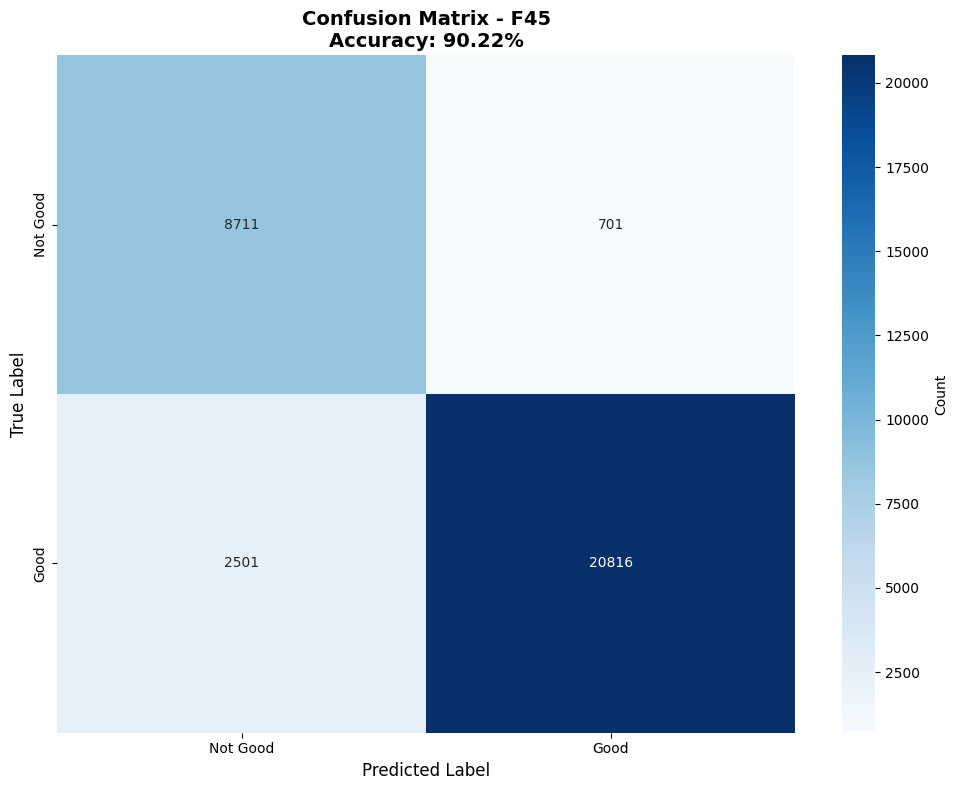

✅ Saved: confusion_matrix_F45.png


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Good', 'Good'],
            yticklabels=['Not Good', 'Good'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {FOCAL_PLANE}\nAccuracy: {accuracy:.2%}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'confusion_matrix_{FOCAL_PLANE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: confusion_matrix_{FOCAL_PLANE}.png")

/tmp/ipython-input-1842671976.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


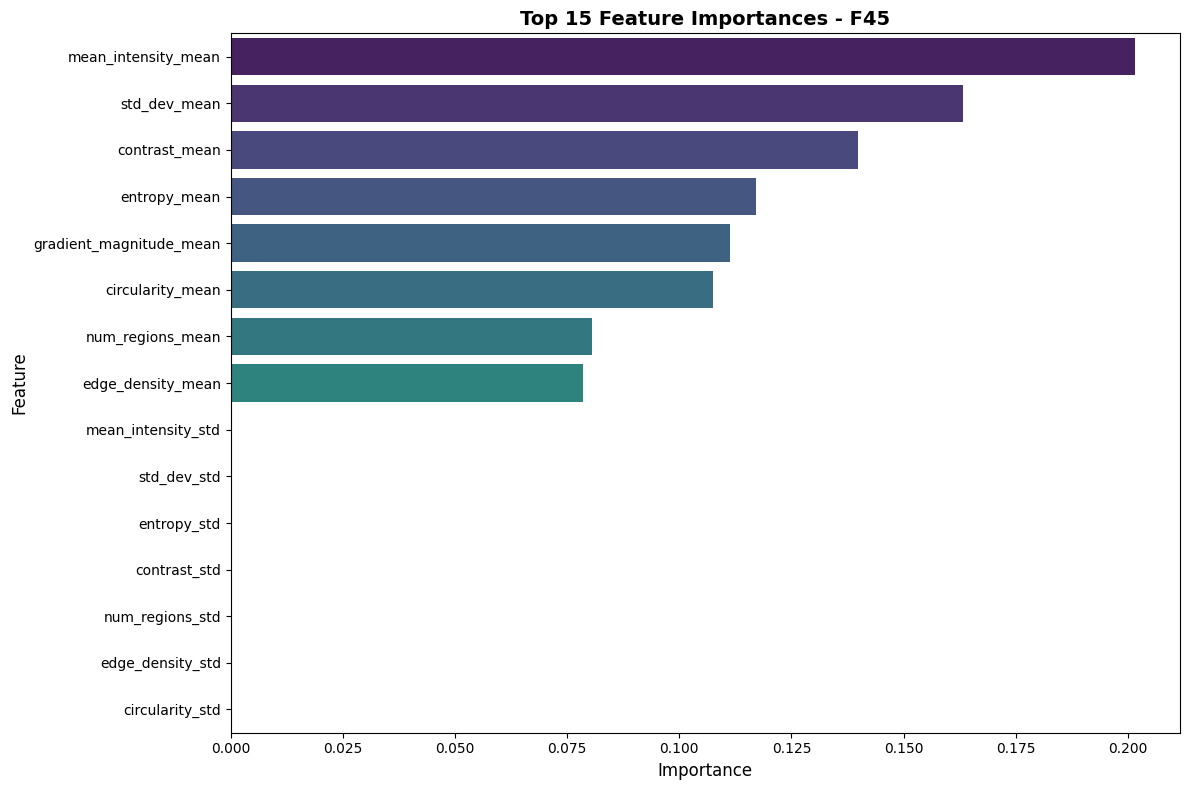

✅ Saved: feature_importance_F45.png

📊 Top 10 Most Important Features:
                feature  importance
    mean_intensity_mean    0.201519
           std_dev_mean    0.163288
          contrast_mean    0.139925
           entropy_mean    0.117125
gradient_magnitude_mean    0.111398
       circularity_mean    0.107557
       num_regions_mean    0.080631
      edge_density_mean    0.078557
     mean_intensity_std    0.000000
            std_dev_std    0.000000


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title(f'Top 15 Feature Importances - {FOCAL_PLANE}',
          fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(f'feature_importance_{FOCAL_PLANE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: feature_importance_{FOCAL_PLANE}.png")
print(f"\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

---
## 🔟 Save Model & All Required Outputs

### ⚠️ IMPORTANT: These 5 files are REQUIRED for ensemble model!

In [ ]:
print("💾 Saving all required outputs...\n")

# 1. Save trained model
model_filename = f'embryo_model_{FOCAL_PLANE}.pkl'
joblib.dump(model, model_filename)
print(f"✅ 1/5: Saved {model_filename}")

# 2. Save scaler
scaler_filename = f'scaler_{FOCAL_PLANE}.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ 2/5: Saved {scaler_filename}")

# 3. Save feature names
feature_names_filename = f'feature_names_{FOCAL_PLANE}.json'
with open(feature_names_filename, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"✅ 3/5: Saved {feature_names_filename}")

# 4. Save evaluation results
results = {
    'focal_plane': FOCAL_PLANE,
    'dataset_size': len(df_features),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'auc_roc': float(auc),
    'confusion_matrix': cm.tolist(),
    'class_distribution': {
        'class_0': int(sum(y == 0)),
        'class_1': int(sum(y == 1))
    },
    'top_10_features': feature_importance.head(10).to_dict('records'),
    'model_params': {
        'n_estimators': 200,
        'max_depth': 10,
        'random_state': 42
    }
}

results_filename = f'results_{FOCAL_PLANE}.json'
with open(results_filename, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✅ 4/5: Saved {results_filename}")

# 5. Confusion matrix already saved above
print(f"✅ 5/5: confusion_matrix_{FOCAL_PLANE}.png (already saved)")

print("\n" + "="*60)
print("🎉 ALL OUTPUTS SAVED SUCCESSFULLY!")
print("="*60)

💾 Saving all required outputs...

✅ 1/5: Saved embryo_model_F45.pkl
✅ 2/5: Saved scaler_F45.pkl
✅ 3/5: Saved feature_names_F45.json
✅ 4/5: Saved results_F45.json
✅ 5/5: confusion_matrix_F45.png (already saved)

🎉 ALL OUTPUTS SAVED SUCCESSFULLY!


---
## 1️⃣1️⃣ Download All Files to Your Computer

In [ ]:
print("📥 Downloading all required files...\n")

# List of files to download
files_to_download = [
    f'embryo_model_{FOCAL_PLANE}.pkl',
    f'scaler_{FOCAL_PLANE}.pkl',
    f'feature_names_{FOCAL_PLANE}.json',
    f'results_{FOCAL_PLANE}.json',
    f'confusion_matrix_{FOCAL_PLANE}.png',
    f'feature_importance_{FOCAL_PLANE}.png'
]

for filename in files_to_download:
    if os.path.exists(filename):
        files.download(filename)
        print(f"✅ Downloaded: {filename}")
    else:
        print(f"⚠️ File not found: {filename}")

print("\n✅ All files downloaded to your Downloads folder!")

📥 Downloading all required files...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: embryo_model_F45.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: scaler_F45.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: feature_names_F45.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: results_F45.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: confusion_matrix_F45.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: feature_importance_F45.png

✅ All files downloaded to your Downloads folder!


---
## 📋 Training Complete - Next Steps

In [ ]:
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print(f"\n📊 Final Results for {FOCAL_PLANE}:")
print(f"   Dataset Size:     {len(df_features)} videos")
print(f"   Accuracy:         {accuracy:.2%}")
print(f"   Recall (Good):    {recall:.2%}")
print(f"   AUC-ROC:          {auc:.3f}")
print(f"\n📦 Files Generated:")
for i, filename in enumerate(files_to_download, 1):
    print(f"   {i}. {filename}")
print(f"\n🚀 Next Steps:")
print(f"   1. Upload these files to shared Google Drive")
print(f"   2. Share results with team")
print(f"   3. Wait for Members 2 & 3 to complete training")
print(f"   4. Member 4 will create ensemble model")
print(f"   5. Expected ensemble accuracy: 85-90%")
print("="*60)

if accuracy >= 0.80:
    print("\n🏆 Excellent performance! Model is ready for ensemble!")
elif accuracy >= 0.70:
    print("\n✅ Good performance! Ready to combine with other models.")
else:
    print("\n⚠️ Performance could be improved. Check dataset quality.")


🎉 TRAINING COMPLETE!

📊 Final Results for F45:
   Dataset Size:     163642 videos
   Accuracy:         90.22%
   Recall (Good):    89.27%
   AUC-ROC:          0.966

📦 Files Generated:
   1. embryo_model_F45.pkl
   2. scaler_F45.pkl
   3. feature_names_F45.json
   4. results_F45.json
   5. confusion_matrix_F45.png
   6. feature_importance_F45.png

🚀 Next Steps:
   1. Upload these files to shared Google Drive
   2. Share results with team
   3. Wait for Members 2 & 3 to complete training
   4. Member 4 will create ensemble model
   5. Expected ensemble accuracy: 85-90%

🏆 Excellent performance! Model is ready for ensemble!
